In [118]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import BorderlineSMOTE
import pandas as pd

In [119]:
# ---- LOAD DATASET ----

df = pd.read_csv("../data/features/filtered_labeled_feature_matrix.csv")
X = df.drop(columns=["performance_class"])
y = df["performance_class"]

In [120]:
# Apply SMOTE once (standard approach)
borderline_smote = KMeansSMOTE( cluster_balance_threshold=0.1, random_state=42)
X_resampled_1, y_resampled_1 = borderline_smote.fit_resample(X, y)

# Convert back to DataFrame
df_smote_1 = pd.DataFrame(X_resampled_1, columns=X.columns)
df_smote_1["performance_class"] = y_resampled_1  # Rename based on actual column name

print("Dataset size after standard SMOTE:", df_smote_1.shape)
value_counts = y_resampled_1.value_counts()
print(value_counts)

Dataset size after standard SMOTE: (607, 26)
performance_class
1    305
0    302
Name: count, dtype: int64


In [121]:
borderline_smote_both = KMeansSMOTE(
    cluster_balance_threshold=0.1,
    sampling_strategy={
        0: len(df_smote_1[df_smote_1['performance_class'] == 0]) * 2,
        1: len(df_smote_1[df_smote_1['performance_class'] == 1]) * 2
    },
    random_state=42
)
X_smote_1 = df_smote_1.drop(columns=["performance_class"])
y_smote_1 = df_smote_1["performance_class"]
X_resampled_final, y_resampled_final = borderline_smote_both.fit_resample(X_smote_1, y_smote_1)


# Convert back to DataFrame
df_final = pd.DataFrame(X_resampled_final, columns=X.columns)
df_final["performance_class"] = y_resampled_final

print("Final dataset size after augmentation:", df_final.shape)
print(y_resampled_final.value_counts())

Final dataset size after augmentation: (1221, 26)
performance_class
1    614
0    607
Name: count, dtype: int64


In [122]:
# Starting with your current augmented dataset (1208 observations)
X_current = df_smote_1.drop(columns=["performance_class"])
y_current = df_smote_1["performance_class"]

# Define a large target count per class
# If you want to get close to 30,000 samples total with 2 classes:
target_count_per_class = 5000  # adjust as needed

# Create a dictionary for sampling_strategy
sampling_dict = {}
for cls in y_current.unique():
    sampling_dict[cls] = target_count_per_class

# Apply SMOTE with large target counts
borderline_smote_large = KMeansSMOTE( cluster_balance_threshold=0.1, sampling_strategy=sampling_dict, random_state=42)
X_resampled_large, y_resampled_large = borderline_smote_large.fit_resample(X_current, y_current)


# Convert back to DataFrame
df_large = pd.DataFrame(X_resampled_large, columns=X_current.columns)
df_large["performance_class"] = y_resampled_large

print("Large dataset size after augmentation:", df_large.shape)
print(y_resampled_large.value_counts())

Large dataset size after augmentation: (10007, 26)
performance_class
0    5004
1    5003
Name: count, dtype: int64


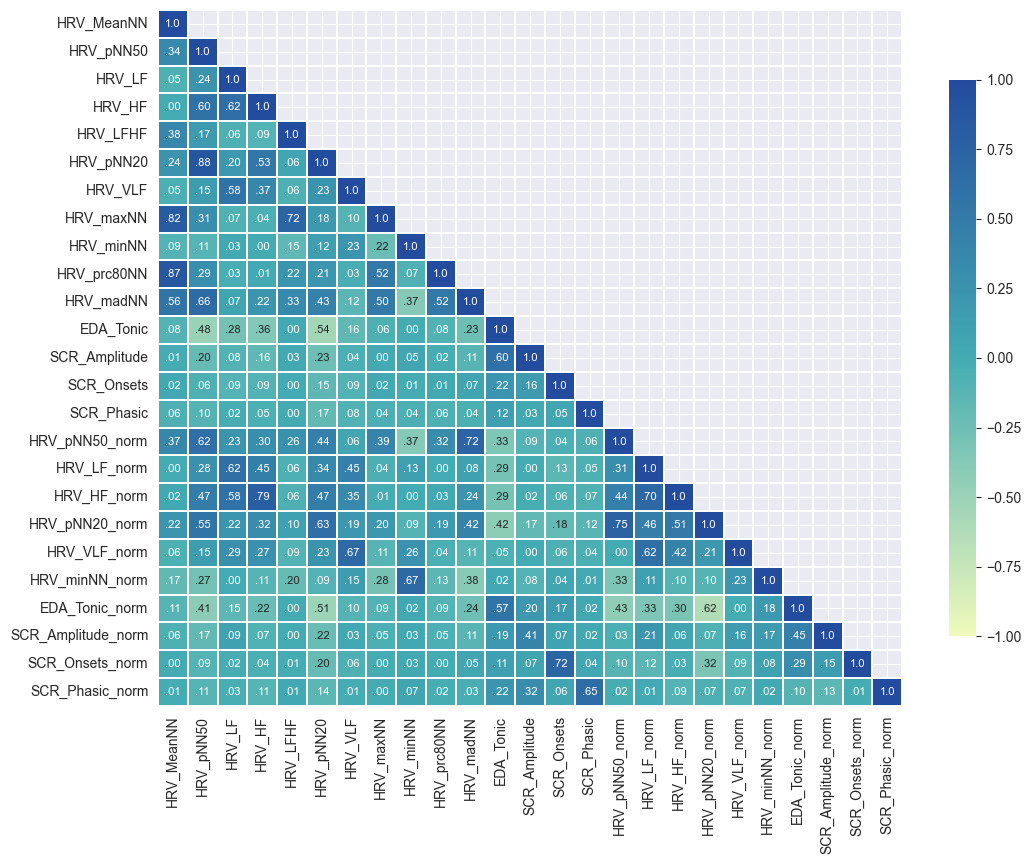

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import numpy as np

# Calculate correlation matrix
corr_matrix_augmented = df_large.drop(columns=["performance_class"]).corr()


# Plot heatmap
# Create a custom colormap


# Create figure with additional space at the bottom for text
plt.figure(figsize=(12, 12))  # Increased height to accommodate text
colors = [
    (0.945, 0.980, 0.733),  # f1fabb (light yellow-green)
    (0.263, 0.671, 0.702),  # 43abb3 (teal)
    #(0.125, 0.580, 0.757),  # 2094c1 (medium blue)
    (0.137, 0.294, 0.620),  # 234b9e (navy blue)
]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=256)

# Create a custom annotation function
def custom_fmt(val):
    # Get absolute value to remove negative sign
    abs_val = abs(val)
    
    # Format based on value
    if abs_val == 1.0:
        return "1.0"  # For exact 1.0, show "1.0"
    else:
        # For values less than 1, show only the decimal part like ".xx"
        return f".{int(abs_val * 100):02d}"

# Create heatmap
heatmap = sns.heatmap(corr_matrix_augmented, 
            mask=np.triu(np.ones_like(corr_matrix_augmented, dtype=bool), k=1),
            annot=True,
            fmt="",  # Empty string because we're using a custom formatter
            annot_kws={"size": 8},  # Adjust text size if needed
            cmap=custom_cmap,  # Standard diverging colormap
            vmin=-1, vmax=1,  # Force scale from -1 to 1
            center=0,  # Ensure zero is at the center
            linewidths=0.2,  # Grid lines for better readability
            cbar_kws={"shrink": 0.8})  # Reduce color bar size

# Adjust the subplot to make room for text at the bottom
plt.subplots_adjust(bottom=0.3)  # Increasebottom margin for text
        
# Apply the custom formatter
for text in heatmap.texts:
    # Get the text value (removing any existing formatting)
    text_value = float(text.get_text().replace('−', '-'))  # Handle unicode minus sign
    # Apply our custom formatting
    text.set_text(custom_fmt(text_value))

# Save with tight layout and higher DPI
plt.savefig("../data/figures/02_b_augmented_feature_correlation_heatmap.pdf", 
            bbox_inches='tight', 
            dpi=300)

# Display plot
plt.show()

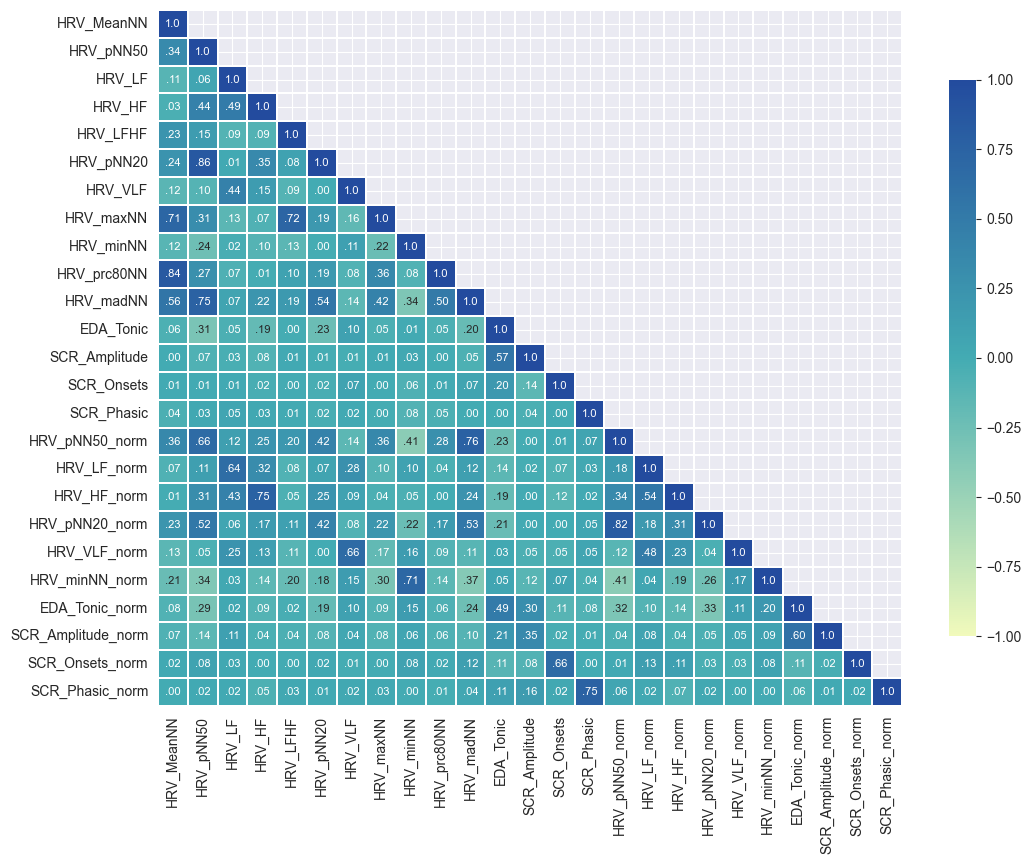

In [124]:
# Calculate correlation matrix
corr_matrix_original = X.corr()


# Plot heatmap

# Create figure with additional space at the bottom for text
plt.figure(figsize=(12, 12))  # Increased height to accommodate text

# Create heatmap
heatmap = sns.heatmap(corr_matrix_original, 
            mask=np.triu(np.ones_like(corr_matrix_original, dtype=bool), k=1),
            annot=True,
            fmt="",  # Empty string because we're using a custom formatter
            annot_kws={"size": 8},  # Adjust text size if needed
            cmap=custom_cmap,  # Standard diverging colormap
            vmin=-1, vmax=1,  # Force scale from -1 to 1
            center=0,  # Ensure zero is at the center
            linewidths=0.2,  # Grid lines for better readability
            cbar_kws={"shrink": 0.8})  # Reduce color bar size

# Apply the custom formatter
for text in heatmap.texts:
    # Get the text value (removing any existing formatting)
    text_value = float(text.get_text().replace('−', '-'))  # Handle unicode minus sign
    # Apply our custom formatting
    text.set_text(custom_fmt(text_value))

# Adjust the subplot to make room for text at the bottom
plt.subplots_adjust(bottom=0.3)  # Increase bottom margin for text
        


# Save with tight layout and higher DPI
plt.savefig("../data/figures/02_b_original_feature_correlation_heatmap.pdf", 
            bbox_inches='tight', 
            dpi=300)

# Display plot
plt.show()